In [1]:
%pip install datasets
%pip install evaluate
%pip install scikit-learn


DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/torchpippy-0.1.1+15dfcd8-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/torchpippy-0.1.1+15dfcd8-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Loading

In [2]:
from datasets import load_dataset
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def set_label(data):
    label_list = [0 for i in range(5)]
    label_list[int(data["rating"]-1)] = 1
    data["labels"] = label_list
    return data

def remove_br_tag(data):
    data["text"] = data["text"].replace("<br />", "")
    return data

data_files={"train":"train.json"}
train_dataset = load_dataset("json", data_files=data_files)
data_files={"test":"test.json"}
test_dataset = load_dataset("json", data_files=data_files)

train_dataset = train_dataset.map(set_label)
train_dataset = train_dataset.map(remove_br_tag)
test_dataset = test_dataset.map(remove_br_tag)

Found cached dataset json (/Users/chuchun/.cache/huggingface/datasets/json/default-e004b4059af2b9f7/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|██████████| 1/1 [00:00<00:00, 822.41it/s]
Found cached dataset json (/Users/chuchun/.cache/huggingface/datasets/json/default-fcde7befffdfd4b4/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|██████████| 1/1 [00:00<00:00, 934.56it/s]


In [5]:


model_name = "google-bert/bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [7]:
TRAIN_VAL_RATIO = 0.85
EPOCH = 3
SEED = 37

In [8]:



def tokenize_title_text(samples):
    texts = f"title:{samples['title']}\nreview:{samples['text']}"
    result = tokenizer(texts, truncation=True, padding='max_length', max_length=128)
    return result

def tokenize_title(samples):
    texts = f"title:{samples['title']}"
    result = tokenizer(texts, truncation=True, padding='max_length', max_length=128)
    return result

# Assume train_dataset and test_dataset are previously loaded datasets
tokenized_datasets = train_dataset.map(tokenize_title_text)
tokenized_datasets_title = train_dataset.map(tokenize_title)

train_size = int(tokenized_datasets["train"].num_rows * TRAIN_VAL_RATIO)
test_size = tokenized_datasets["train"].num_rows - train_size
splited_dataset = tokenized_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=SEED
)

tokenized_test_dataset = test_dataset.map(tokenize_title_text)
tokenized_test_dataset_title = test_dataset.map(tokenize_title)




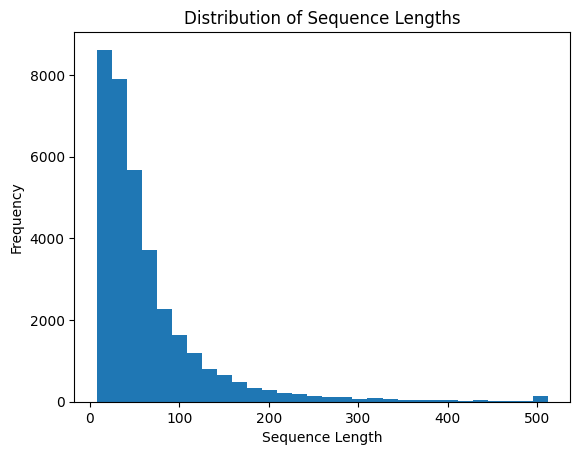

In [14]:
"""
for calculating the distribution of the sequence length
"""
def cal_distribution(samples):
    samples["length"] = len(samples["input_ids"])
    return samples

for_cal_dist = tokenized_datasets.map(
    cal_distribution
)

sequence_lengths = for_cal_dist["train"]["length"]
# Calculate statistics
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
percentile_90 = np.percentile(sequence_lengths, 90)

# Plot histogram
plt.hist(sequence_lengths, bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
"""
Use one-hot encoding for the labels
"""

# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

classes = ['1', '2', '3', '4', '5']
class2id = {clas: id for id, clas in enumerate(classes)}
id2class = {id: clas for clas, id in class2id.items()}

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = 1/(1 + np.exp(-predictions))
#     predictions = (predictions > 0.5).astype(int).reshape(-1)
#     return {
#         'accuracy': evaluate.load("accuracy").compute(predictions=predictions, references=labels),
#         'f1': evaluate.load("f1").compute(predictions=predictions, references=labels, average='weighted'),
#     }

# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, id2label=id2class, label2id=class2id)

# batch_size = 4
# logging_steps = len(splited_dataset["train"]) // batch_size
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# training_args = TrainingArguments(
#     gradient_accumulation_steps=2,
#     output_dir="Hw2/output",
#     run_name="second_try",
#     overwrite_output_dir=True,
#     learning_rate=0.01,
#     weight_decay=0.01,
#     num_train_epochs=EPOCH,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     push_to_hub=False,
#     report_to="none",
#     fp16=False,
#     # use_mps_device=True,  ### FIX
#     logging_steps=logging_steps,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=splited_dataset["train"],
#     eval_dataset=splited_dataset["test"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

# trainer.train()
# trainer.save_model("output/weights")


In [ ]:
"""
Use scalar labels
"""

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
import evaluate

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': evaluate.load("accuracy").compute(predictions=predictions, references=labels),
        'f1': evaluate.load("f1").compute(predictions=predictions, references=labels, average='weighted'),
    }


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

batch_size = 4
logging_steps = len(splited_dataset["train"]) // batch_size
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    gradient_accumulation_steps=2,
    output_dir="Hw2/output",
    run_name="second_try",
    overwrite_output_dir=True,
    learning_rate=0.01,
    weight_decay=0.01,
    num_train_epochs=EPOCH,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    fp16=False,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=splited_dataset["train"],
    eval_dataset=splited_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("output/weights")


In [ ]:
"""
Validation
"""
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


eval_dataloader = DataLoader(
    splited_dataset["test"], batch_size=20, collate_fn=data_collator
)

# Load the model from a checkpoint
checkpoint = "second_try"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(classes))

# Prepare lists to store the predictions and the true labels
predictions = []
targets = []

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move the model to the appropriate device
model.to(device)

# Set the model to evaluation mode
model.eval()

# Loop over the batches in the validation DataLoader
for batch in tqdm(eval_dataloader):
    # No need to calculate gradients for validation, saves memory and computations
    with torch.no_grad():
        # Convert the labels from one-hot encoding to class names and add them to the targets list
        labels = [id2class[lst.index(1.0)] for lst in batch["labels"].numpy().tolist()]
        targets.extend(labels)

        # Move the batch tensors to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Perform a forward pass on the model and get the logits
        outputs = model(**batch).logits

        # Get the predicted class indices
        prediction = outputs.argmax(dim=1).tolist()

        # Convert the predicted class indices to class names and add them to the predictions list
        predictions.extend([classes[pred] for pred in prediction])

# Load the confusion matrix metric
confusion_metric = evaluate.load("confusion_matrix")

# Compute the confusion matrix for the targets and predictions
results = confusion_metric.compute(references=targets, predictions=predictions)

# Print the confusion matrix
print(results)

In [ ]:
"""
Inference
"""

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
eval_dataloader = DataLoader(
    tokenized_test_dataset["test"], batch_size=20, collate_fn=data_collator
)


checkpoint = "first_try"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(classes))

predictions = []
index = [f"index_{i}" for i in range(tokenized_test_dataset["test"].num_rows)]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()
for batch in tqdm(eval_dataloader):
    with torch.no_grad():
        batch = batch.to(device)
        outputs = model(**batch)
        prediction = outputs.logits.argmax(dim=1).tolist()
        predictions.extend([classes[pred] for pred in prediction])

results = pd.DataFrame({"index": index, "rating": predictions})
results.to_csv(f"predictions_{checkpoint.split('/')[-1]}.csv", index=False)
